In [1]:
import matplotlib.pyplot as plt
import numpy as np

import data_handling
import utils
from gaussian_spectral_clustering import (compute_pcs_and_project,
                                          initial_class_assignment,
                                          iterate_clustering,
                                          compute_class_statistics,
                                          compute_posterior_probability_and_assign,
                                          compute_multivariate_gaussian_statistics
                                         )
%matplotlib inline

In [2]:
# matplotlib settings for figure size and colormap
plt.rcParams['figure.figsize'] = [20, 15];
plt.rcParams['image.cmap'] = plt.gray();

<Figure size 1440x1080 with 0 Axes>

In [3]:
data_path = r'C:\Users\Jon\PycharmProjects\gaussian-spectral-clustering\ECE567_data_package_1\\'
img_filename = data_path + '20130408_155259_archer_hsi_0021_crop_NUC_ELM.dat'
img_truth_filename = data_path + '20130408_155259_archer_hsi_0021_truth.dat'

In [4]:
hsi_data_mat, sz, truth_data_mat = data_handling.load_archer_data(img_filename, img_truth_filename)

C:\Users\Jon\Miniconda3\envs\ece567\lib\site-packages\spectral\io\envi.py:195: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.setttings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Header parameter names converted to lower case.


In [5]:
# Get indices for each class in the truth
blue_serials = list(range(30,35)) + list(range(40,45))\
                + list(range(60,65)) + list(range(50,53))

brown_serials = list(range(35,40)) + list(range(45,50))\
                 + list(range(65,70)) + list(range(55,58))
camo_serials = list(range(20,25))

print('Blue serial numbers:', blue_serials)
print('Brown serial numbers:', brown_serials)
print('Camo serial numbers:', camo_serials)

blue_ix = data_handling.serials_to_idxs(blue_serials, truth_data_mat)
brown_ix = data_handling.serials_to_idxs(brown_serials, truth_data_mat)
camo_ix = data_handling.serials_to_idxs(camo_serials, truth_data_mat)

background_ix = data_handling.serials_to_idxs([0], truth_data_mat)
white_ix = data_handling.serials_to_idxs([10], truth_data_mat)
black_ix = data_handling.serials_to_idxs([11], truth_data_mat)

print('Num blue pixels:', blue_ix.shape[0])
print('Num brown pixels:', brown_ix.shape[0])
print('Num background pixels:', background_ix.shape[0])
print('Num camo pixels:', camo_ix.shape[0])
print('Num white pixels:', white_ix.shape[0])
print('Num black pixels:', black_ix.shape[0])

Blue serial numbers: [30, 31, 32, 33, 34, 40, 41, 42, 43, 44, 60, 61, 62, 63, 64, 50, 51, 52]
Brown serial numbers: [35, 36, 37, 38, 39, 45, 46, 47, 48, 49, 65, 66, 67, 68, 69, 55, 56, 57]
Camo serial numbers: [20, 21, 22, 23, 24]
Num blue pixels: 276
Num brown pixels: 217
Num background pixels: 503305
Num camo pixels: 164
Num white pixels: 19
Num black pixels: 19


## Compute PCs and Project

In [6]:
x_pca, eig_vecs = compute_pcs_and_project(hsi_data_mat)

In [7]:
def reshape_pca_band(X, band, sz):
    nl, ns, nb = sz
    # return X.transpose().reshape([nl, ns, nb], order='F')[:, :, band]
    return X[band, :].reshape([nl, ns], order='F')

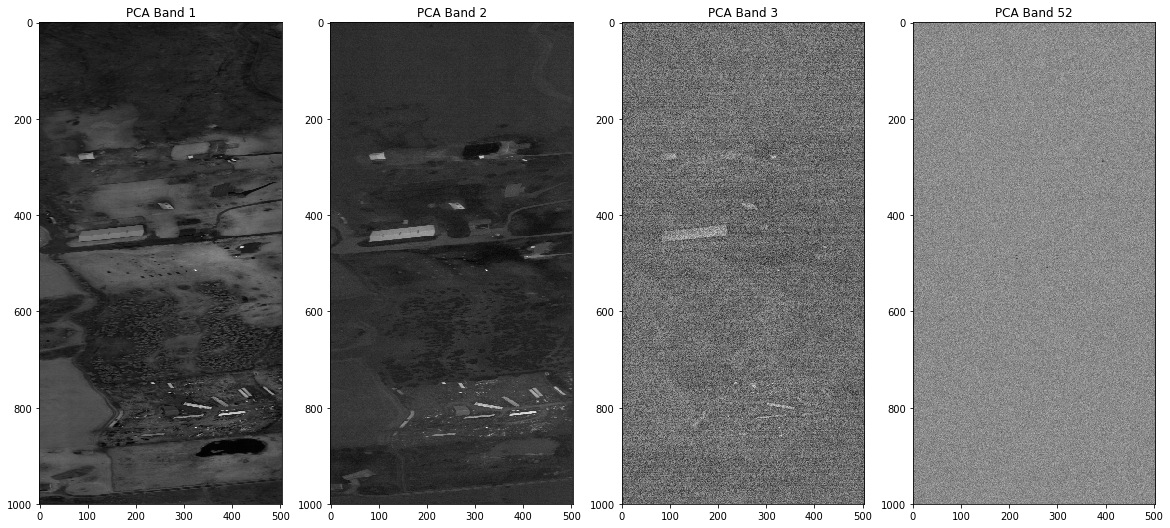

In [8]:
# Plot various bands from the image
# Squeeze() is needed to remove the single-dimensional band dimension
# before plotting (e.g. (nl, ns, 1) -> (nl, ns))
f, (plot1, plot2, plot3, plot4) = plt.subplots(1, 4)
plot1.imshow(reshape_pca_band(x_pca, 0, sz), cmap=plt.gray());
plot1.set_title('PCA Band 1');

plot2.imshow(reshape_pca_band(x_pca, 1, sz), cmap=plt.gray());
plot2.set_title('PCA Band 2');

plot3.imshow(reshape_pca_band(x_pca, 2, sz), cmap=plt.gray());
plot3.set_title('PCA Band 3');

plot4.imshow(reshape_pca_band(x_pca, 51, sz), cmap=plt.gray());
plot4.set_title('PCA Band 52');

## Split data into leading and trailing-order PCs

In [9]:
# Number of leading order PCs (i.e. bands [0, K])
K = 3

leading_order_pcs = x_pca[:K, :]
trailing_order_pcs = x_pca[K:, :]

## (Optional) Cull Pixels

In [10]:
#outlier_ixs = compute_multivariate_gaussian_statistics(trailing_order_pcs)

In [11]:
#leading_order_pcs = np.delete(leading_order_pcs, outlier_ixs, axis=1)

## Initial Class Assignment (leading-order PCs)

In [12]:
num_classes = 7

In [13]:
cmi, cm, cc = initial_class_assignment(leading_order_pcs, num_classes)

In [14]:
#cmi, cm, cc = initial_class_assignment(leading_order_pcs, num_classes, method='select', init_indices=[blue_ix[0], brown_ix[0], camo_ix[0], white_ix[0], black_ix[0], background_ix[500], background_ix[50000]])

In [15]:
np.random.seed(12345)
final_class_ixs = iterate_clustering(leading_order_pcs, cmi, num_classes, 500)

class counts [72455 71589 72060 71794 71486 72433 72183]
Finished iteration # 0
class counts [66496 69675 65211 78270 69565 87277 67506]
Finished iteration # 1
class counts [44337 72073 62891 85423 72724 98086 68466]
Finished iteration # 2
class counts [ 33448  72426  63986  87645  73873 103132  69490]
Finished iteration # 3
class counts [ 27225  71997  66261  88148  74148 106202  70019]
Finished iteration # 4
class counts [ 22750  71648  68595  88538  73256 109559  69654]
Finished iteration # 5
class counts [ 19352  70653  70067  88481  72747 113759  68941]
Finished iteration # 6
class counts [ 16753  69882  70990  88164  73477 117240  67494]
Finished iteration # 7
class counts [ 14820  69083  71385  87544  74495 119937  66736]
Finished iteration # 8
class counts [ 13528  67676  71635  85967  77031 122338  65825]
Finished iteration # 9
class counts [ 12532  66572  72426  83705  80060 123545  65160]
Finished iteration # 10
class counts [ 11801  64886  73182  79870  83594 125542  65125]

class counts [  9977  69160  62858  69343  81528 138715  72419]
Finished iteration # 94
class counts [  9976  69538  62461  69253  81612 138839  72321]
Finished iteration # 95
class counts [  9947  69464  62122  69475  81940 138534  72518]
Finished iteration # 96
class counts [  9970  69969  61500  69224  82445 138380  72512]
Finished iteration # 97
class counts [ 10025  70389  61265  69017  82839 138031  72434]
Finished iteration # 98
class counts [ 10047  70492  61205  68635  83250 138242  72129]
Finished iteration # 99
class counts [ 10058  70807  60756  68441  83230 138449  72259]
Finished iteration # 100
class counts [  9973  70963  60676  68454  83265 138404  72265]
Finished iteration # 101
class counts [  9854  71359  60234  68253  83543 138295  72462]
Finished iteration # 102
class counts [  9820  71869  59863  68327  83410 138286  72425]
Finished iteration # 103
class counts [  9839  71833  59682  68549  83637 138286  72174]
Finished iteration # 104
class counts [  9824  72021

class counts [  8983  88552  22304  64068 115078 140871  64144]
Finished iteration # 187
class counts [  8925  88627  22091  63777 115240 141145  64195]
Finished iteration # 188
class counts [  8941  89092  21928  63943 114856 140791  64449]
Finished iteration # 189
class counts [  8969  89108  21838  63851 114732 141075  64427]
Finished iteration # 190
class counts [  9000  89202  21754  64283 114128 141210  64423]
Finished iteration # 191
class counts [  9004  89549  21753  64577 113609 141177  64331]
Finished iteration # 192
class counts [  9016  89687  21571  64707 113337 141263  64419]
Finished iteration # 193
class counts [  9016  89709  21459  64665 113134 141450  64567]
Finished iteration # 194
class counts [  8983  89644  21569  64627 112949 141400  64828]
Finished iteration # 195
class counts [  9043  89851  21352  64682 113151 141251  64670]
Finished iteration # 196
class counts [  9059  89610  21385  64800 113057 141351  64738]
Finished iteration # 197
class counts [  9026 

class counts [  9052  89364  21088  73557 106443 140839  63657]
Finished iteration # 280
class counts [  9045  89660  21086  73634 106064 140856  63655]
Finished iteration # 281
class counts [  9048  89893  21008  73603 105824 140842  63782]
Finished iteration # 282
class counts [  9060  89839  20982  73287 105826 141198  63808]
Finished iteration # 283
class counts [  9009  89462  21101  73684 105880 141243  63621]
Finished iteration # 284
class counts [  9080  89333  21193  73504 106078 141505  63307]
Finished iteration # 285
class counts [  9023  89353  21210  73855 106051 141265  63243]
Finished iteration # 286
class counts [  9000  89558  21063  73703 105858 141484  63334]
Finished iteration # 287
class counts [  9003  89684  21003  73574 105875 141641  63220]
Finished iteration # 288
class counts [  8991  89517  21030  73694 105843 141473  63452]
Finished iteration # 289
class counts [  9055  89585  21069  73606 105745 141665  63275]
Finished iteration # 290
class counts [  9071 

class counts [  8809  87897  21018  84958  99082 141574  60662]
Finished iteration # 373
class counts [  8859  88116  21030  84721  98937 141518  60819]
Finished iteration # 374
class counts [  8848  87919  21147  85001  98971 141600  60514]
Finished iteration # 375
class counts [  8878  87898  21134  84959  98741 141554  60836]
Finished iteration # 376
class counts [  8937  87797  21124  85287  98596 141485  60774]
Finished iteration # 377
class counts [  8922  87907  21132  85472  98465 141271  60831]
Finished iteration # 378
class counts [  8890  87535  21143  85588  98530 141364  60950]
Finished iteration # 379
class counts [  8859  87343  21165  85723  99031 141192  60687]
Finished iteration # 380
class counts [  8813  87523  21073  85586  98900 141346  60759]
Finished iteration # 381
class counts [  8819  87864  21095  85663  98912 141239  60408]
Finished iteration # 382
class counts [  8786  88184  21013  85605  98734 141342  60336]
Finished iteration # 383
class counts [  8850 

class counts [  8762  93099  21083  88685  91451 143960  56960]
Finished iteration # 466
class counts [  8790  92887  21121  88418  91505 144082  57197]
Finished iteration # 467
class counts [  8792  92975  21159  88665  91207 143955  57247]
Finished iteration # 468
class counts [  8762  92981  21059  88225  91410 144170  57393]
Finished iteration # 469
class counts [  8737  93200  21067  87671  91461 144300  57564]
Finished iteration # 470
class counts [  8757  93074  20986  87861  91596 144236  57490]
Finished iteration # 471
class counts [  8753  93289  20939  87583  91673 144284  57479]
Finished iteration # 472
class counts [  8735  93710  21066  87267  91438 144543  57241]
Finished iteration # 473
class counts [  8676  93815  21099  87810  91208 144266  57126]
Finished iteration # 474
class counts [  8683  94268  21049  87647  91169 143909  57275]
Finished iteration # 475
class counts [  8776  94069  20997  87218  91408 144235  57297]
Finished iteration # 476
class counts [  8788 

In [16]:
# Code taken from https://github.com/bids/colormap/blob/master/parula.py to create the Parula colormap
# Parula is MATLAB's default and is being used to better compare this Python code to the MATLAB results given
from matplotlib.colors import LinearSegmentedColormap

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

plt.register_cmap(cmap=parula_map)
cmap = plt.get_cmap('parula')

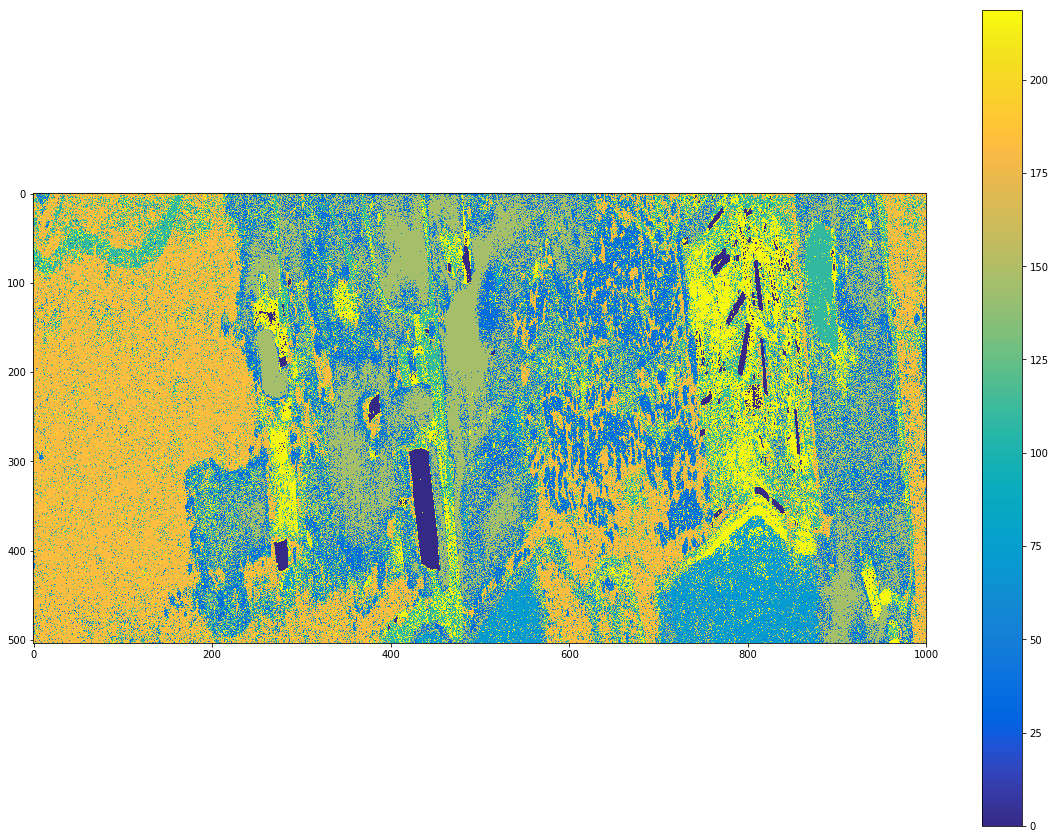

In [17]:
nl, ns, nb = sz
fig, axs = plt.subplots(nrows=1, ncols=1);
cmap = plt.get_cmap('parula')

im = axs.imshow(np.rot90(final_class_ixs.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);

fig.colorbar(im, ax=axs);

In [18]:
target_ix_list = [blue_ix, brown_ix, camo_ix, white_ix, black_ix]

In [19]:
# Produce false alarm counts for the background
for cnt, target_ix in enumerate(target_ix_list):
    # Subtract total number of target pixels by the number we "should" have based on truth target_ix
    print('False alarm for target_ix {}: {}'.format(cnt, final_class_ixs[final_class_ixs == cnt].shape[0] - target_ix.shape[0]))

False alarm for target_ix 0: 8447
False alarm for target_ix 1: 97987
False alarm for target_ix 2: 20955
False alarm for target_ix 3: 85805
False alarm for target_ix 4: 88980


In [20]:
from sklearn.cluster import KMeans

In [21]:
km = KMeans(n_clusters=num_classes).fit(hsi_data_mat.transpose())

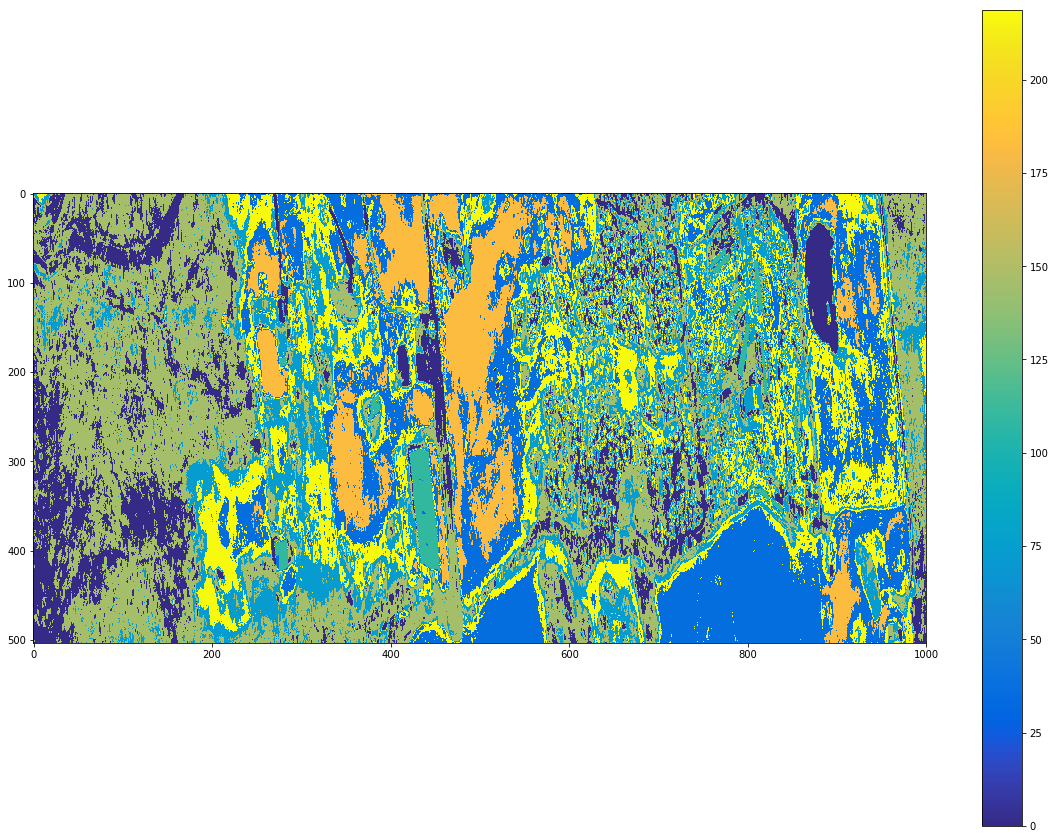

In [22]:
#fig, axs = plt.subplots(nrows=10, ncols=1);
nl, ns, nb = sz
fig, axs = plt.subplots(nrows=1, ncols=1);
cmap = plt.get_cmap('parula')

im = axs.imshow(np.rot90(km.labels_.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);

fig.colorbar(im, ax=axs);

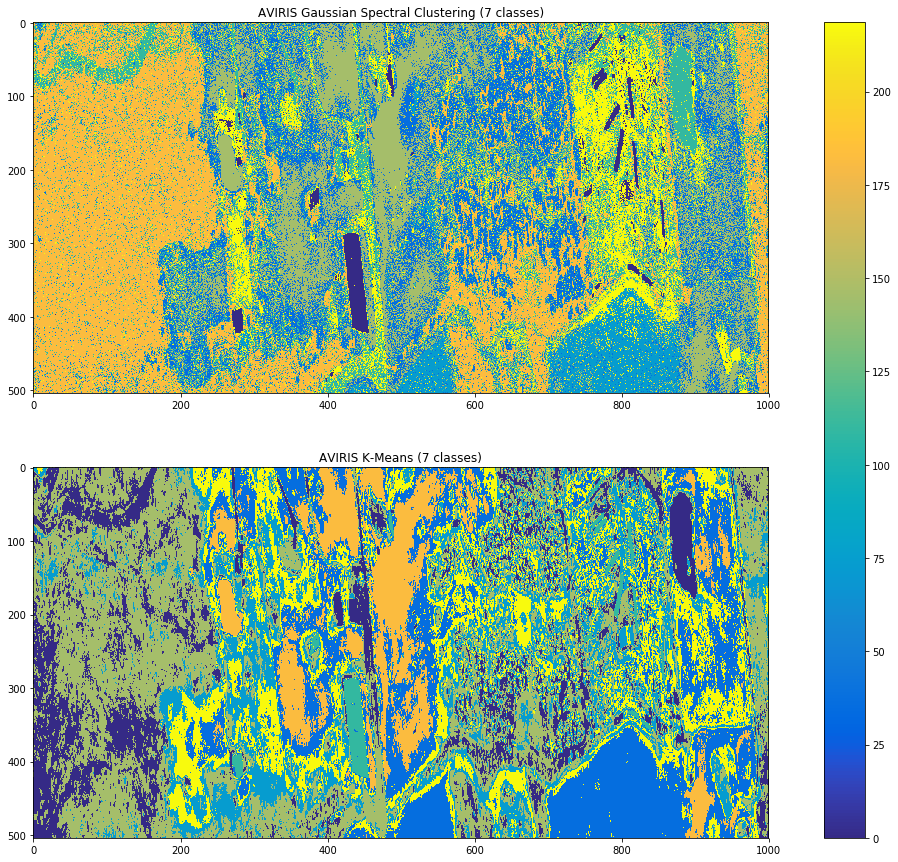

In [23]:
# Side by side comparison
fig, axs = plt.subplots(nrows=2, ncols=1);
cmap = plt.get_cmap('parula')

gsc_im = axs[0].imshow(np.rot90(final_class_ixs.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);
km_im = axs[1].imshow(np.rot90(km.labels_.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);

axs[0].set_title('AVIRIS Gaussian Spectral Clustering ({} classes)'.format(num_classes))
axs[1].set_title('AVIRIS K-Means ({} classes)'.format(num_classes))
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(gsc_im, ax=axs);